In [2]:
%pip install -q pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


# Model

In [2]:
import os
from types import SimpleNamespace 

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split
from pytorch_lightning.callbacks import ModelCheckpoint

from torchvision.datasets.mnist import MNIST
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# ------------------------------------------------------------------------------
# Basic NN modules, enhanced with bn/relu. 
# ------------------------------------------------------------------------------
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bn=False, relu=False):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride)
        self.relu = nn.LeakyReLU() if relu else None
        self.bn = nn.BatchNorm2d(out_channels) if bn else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None: x = self.bn(x)
        if self.relu is not None: x = self.relu(x)
        return x
    
class Deconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, bn=False, relu=False):
        super(Deconv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, output_padding=output_padding)
        self.relu = nn.LeakyReLU() if relu else None
        self.bn = nn.BatchNorm2d(out_channels) if bn else None

    def forward(self, x):
        x = self.deconv(x)
        if self.bn is not None: x = self.bn(x)
        if self.relu is not None: x = self.relu(x)
        return x

class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bn=False, relu=False):
        super(Linear, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.fc = nn.Linear(in_channels, out_channels)
        self.relu = nn.LeakyReLU() if relu else None
        self.bn = nn.BatchNorm1d(out_channels) if bn else None

    def forward(self, x):
        x = self.fc(x)
        if self.bn is not None: x = self.bn(x)
        if self.relu is not None: x = self.relu(x)
        return x

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

# ------------------------------------------------------------------------------
# The main VAE model.
# ------------------------------------------------------------------------------
class LitVAE(pl.LightningModule):

    def __init__(self, args):
        super().__init__()
        self.hidden_size = args.hidden_size
        # --------------------------- encoder ---------------------------
        # input: (N, 1, H, W) single-channel images with values in (0, 1)
        # output: (hidden_size) mu, log(sigma^2) for Q(z|X)
        # ---------------------------------------------------------------
        # encoder backbone 
        self.encoder = nn.Sequential(
            Conv2d(1, 8, 3, padding=1, stride=2, bn=True, relu=True),
            Conv2d(8, 8, 3, padding=1, stride=1, bn=True, relu=True),
            
            Conv2d(8, 16, 3, padding=1, stride=2, bn=True, relu=True),
            Conv2d(16, 16, 3, padding=1, stride=1, bn=True, relu=True),
            
            Conv2d(16, 32, 3, padding=1, stride=2, bn=True, relu=True),
            Conv2d(32, 32, 3, padding=1, stride=1, bn=True, relu=True),
            
            Conv2d(32, 32, 3, padding=1, stride=2, bn=True, relu=True),
            Conv2d(32, 32, 3, padding=1, stride=1, bn=True, relu=True),

            nn.Flatten(),
            Linear(32 * 2 * 2, self.hidden_size, bn=True, relu=True),
        )
        # encoder head for mu
        self.encoder_mu = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
        )
        # encoder head for log(var)
        self.encoder_log_var = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
        )
        # --------------------------- decoder ---------------------------
        # input: (hidden_size) z sampled from Q(z|X)
        # output: (N, 1, H, W) reconstructed images,
        #         unnormalized logits, apply sigmoid to get final output
        # ---------------------------------------------------------------
        self.decoder = nn.Sequential(
            Linear(self.hidden_size, 32 * 2 * 2, bn=True, relu=True),
            View(-1, 32, 2, 2),

            Deconv2d(32, 32, 3, padding=1, stride=2, output_padding=1, bn=True, relu=True),
            Conv2d(32, 32, 3, padding=1, stride=1, bn=True, relu=True),
            
            Deconv2d(32, 16, 3, padding=1, stride=2, output_padding=0, bn=True, relu=True),
            Conv2d(16, 16, 3, padding=1, stride=1, bn=True, relu=True),
            
            Deconv2d(16, 8, 3, padding=1, stride=2, output_padding=1, bn=True, relu=True),
            Conv2d(8, 8, 3, padding=1, stride=1, bn=True, relu=True),
            
            Deconv2d(8, 1, 3, padding=1, stride=2, output_padding=1, bn=True, relu=True),
            Conv2d(1, 1, 3, padding=1, stride=1, bn=False, relu=False),
        )

    def encode(self, x):
        x_feats = self.encoder(x)
        z_mu = self.encoder_mu(x_feats)
        z_log_var = self.encoder_log_var(x_feats)
        z_normal = torch.randn(x.size(0), self.hidden_size).to(self.device)
        z = torch.exp(z_log_var * 0.5) * z_normal + z_mu
        return z, z_mu, z_log_var

    def forward(self, x):
        z, z_mu, z_log_var = self.encode(x)
        x_hat = self.decoder(z)
        return x_hat, z, z_mu, z_log_var

    def criterion(self, batch, batch_idx):
        x, y = batch
        x_hat, z, z_mu, z_log_var = self.forward(x)
        recon_loss = F.binary_cross_entropy_with_logits(x_hat, x, reduction="sum")
        kldiv_loss = (0.5 * (-(z_log_var + 1) + z_log_var.exp() + z_mu.pow(2))).sum()
        recon_loss /= x.size(0); kldiv_loss /= x.size(0)
        loss = recon_loss + kldiv_loss
        return {"loss": loss, "recon_loss": recon_loss, "kldiv_loss": kldiv_loss}

    def log_scalar(self, split, **kwargs):
        for key, value in kwargs.items():
            self.log(f"{split}/{key}", value, on_epoch=True)

    def training_step(self, batch, batch_idx):
        metrics = self.criterion(batch, batch_idx)
        self.log_scalar("train", **metrics)
        return metrics["loss"]

    def validation_step(self, batch, batch_idx):
        metrics = self.criterion(batch, batch_idx)
        self.log_scalar("val", **metrics)

    def test_step(self, batch, batch_idx):
        metrics = self.criterion(batch, batch_idx)
        self.log_scalar("test", **metrics)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Training

In [3]:
def main():
    pl.seed_everything(1234)

    # replace with argparser when running from CLI
    args = SimpleNamespace(
        batch_size=32,
        max_epochs=20,
        hidden_size=10,
        gpus=0,     # set to > 0 to enable cuda
    )
    
    dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = MNIST('', train=False, download=True, transform=transforms.ToTensor())
    mnist_train, mnist_val = random_split(dataset, [55000, 5000])

    train_loader = DataLoader(mnist_train, batch_size=args.batch_size)
    val_loader = DataLoader(mnist_val, batch_size=args.batch_size)
    test_loader = DataLoader(mnist_test, batch_size=args.batch_size)

    model = LitVAE(args)

    checkpoint_callback = ModelCheckpoint(
        monitor='val/loss',
        filename='vae-epoch={epoch:02d}',
        mode='min',
    )
    trainer = pl.Trainer.from_argparse_args(args)
    trainer.callbacks += [checkpoint_callback]
    trainer.fit(model, train_loader, val_loader)
    print('best checkpoint:', os.path.relpath(checkpoint_callback.best_model_path))

    result = trainer.test(test_dataloaders=test_loader)
    print(result)


if __name__ == '__main__':
    main()

Global seed set to 1234


9913344it [00:10, 990779.78it/s]                              


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


29696it [00:00, 3930761.88it/s]          

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  7%|▋         | 122880/1648877 [00:00<00:01, 1226823.89it/s]

1649664it [00:02, 670023.14it/s]                             


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


5120it [00:00, 12866888.24it/s]         

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!



/Users/zpzhou/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1614389903258/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | encoder         | Sequential | 38.2 K
1 | encoder_mu      | Sequential | 110   
2 | encoder_log_var | Sequential | 110   
3 | decoder         | Sequential 

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/zpzhou/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Global seed set to 1234


Epoch 0:   0%|          | 1/1876 [00:00<02:08, 14.63it/s, loss=669, v_num=0]

/Users/zpzhou/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 1876/1876 [00:56<00:00, 33.05it/s, loss=135, v_num=0]
best checkpoint: lightning_logs/version_0/checkpoints/vae-epoch=epoch=19.ckpt
Testing:   4%|▍         | 13/313 [00:00<00:02, 128.30it/s]

/Users/zpzhou/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 313/313 [00:02<00:00, 127.33it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/kldiv_loss': 8.309773445129395,
 'test/loss': 132.6034393310547,
 'test/recon_loss': 124.29364776611328}
--------------------------------------------------------------------------------
[{'test/loss': 132.6034393310547, 'test/recon_loss': 124.29364776611328, 'test/kldiv_loss': 8.309773445129395}]


# Testing

In [3]:
# ------------------------------------------------------------------------------
# Loads the best checkpoint and the data.
# ------------------------------------------------------------------------------
# replace with argparser when running from CLI
args = SimpleNamespace(
    batch_size=32,
    hidden_size=10,
    gpus=0,     # set to > 0 to enable cuda
)

# load from best checkpoint, printed in the training output
model = LitVAE.load_from_checkpoint('lightning_logs/version_0/checkpoints/vae-epoch=epoch=19.ckpt', args=args)
model.eval()

mnist_test = MNIST('', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=args.batch_size)

## Latent Space

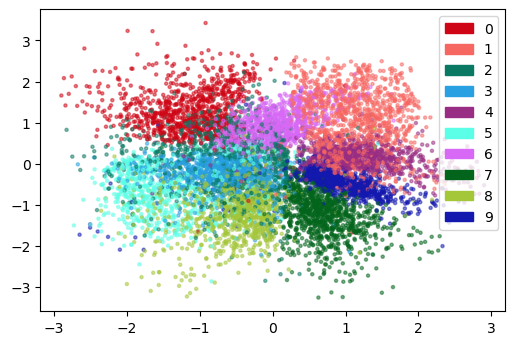

In [28]:
latent_space = []
labels = []
for x, y in test_loader:
    _, _, z, _ = model(x)
    z = z.detach().cpu().numpy()
    latent_space += [z]
    labels += [y]

latent_space = np.concatenate(latent_space, axis=0)
latent_space = PCA(2).fit_transform(latent_space)
latent_space_x, latent_space_y = zip(*latent_space)
labels = np.concatenate(labels)

from matplotlib.patches import Patch
cmap = np.random.rand(10, 3)
plt.figure(dpi=100)
plt.scatter(latent_space_x, latent_space_y, color=[cmap[y] for y in labels], s=5, alpha=0.5)
plt.legend(handles=[Patch(color=cmap[y], label=str(y)) for y in range(10)])
plt.show()

## Reconstruction

[0] ====== digit: 2 ======


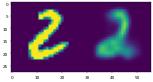

[1] ====== digit: 8 ======


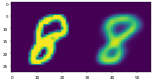

[2] ====== digit: 3 ======


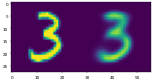

[3] ====== digit: 0 ======


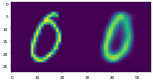

[4] ====== digit: 0 ======


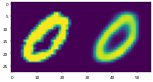

In [17]:
for i in range(5):
    idx = np.random.randint(0, len(mnist_test))
    x, y = mnist_test[idx]
    _, _, z, _ = model(x.unsqueeze(1))
    x_hat = torch.sigmoid(model.decoder(z))
    x = x.permute(1, 2, 0).cpu().numpy().squeeze()
    x_hat = x_hat.squeeze(1).permute(1, 2, 0).detach().cpu().numpy().squeeze()
    print(f"[{i}] ====== digit: {y} ======")
    plt.figure(dpi=30)
    plt.imshow(np.c_[x, x_hat])
    plt.show()

## Interpolation

[0] ====== digit: 1 -> 3 ======


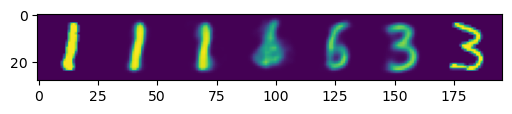

[1] ====== digit: 9 -> 1 ======


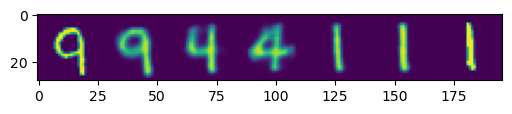

[2] ====== digit: 2 -> 3 ======


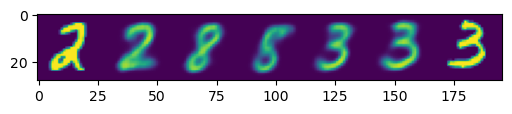

[3] ====== digit: 7 -> 1 ======


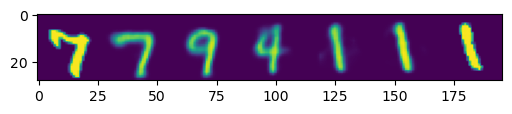

[4] ====== digit: 8 -> 3 ======


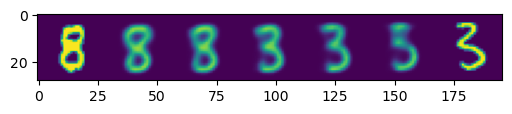

In [15]:
for i in range(5):
    idx1 = np.random.randint(0, len(mnist_test))
    idx2 = np.random.randint(0, len(mnist_test))

    # input 1
    x1, y1 = mnist_test[idx1]
    _, _, z1, _ = model(x1.unsqueeze(1))
    x1 = x1.permute(1, 2, 0).cpu().numpy().squeeze()

    # input 2
    x2, y2 = mnist_test[idx2]
    _, _, z2, _ = model(x2.unsqueeze(1))
    x2 = x2.permute(1, 2, 0).cpu().numpy().squeeze()

    # interpolation
    ims = []
    for lam in [0, 0.25, 0.5, 0.75, 1]:
        z = (1 - lam) * z1 + lam * z2
        x_hat = torch.sigmoid(model.decoder(z))
        x_hat = x_hat.squeeze(1).permute(1, 2, 0).detach().cpu().numpy().squeeze()
        ims.append(x_hat)

    print(f"[{i}] ====== digit: {y1} -> {y2} ======")
    plt.figure(dpi=100)
    plt.imshow(np.hstack([x1] + ims + [x2]))
    plt.show()

## Sample and Generate

[0] sampled


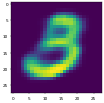

[1] sampled


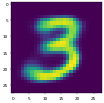

[2] sampled


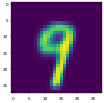

[3] sampled


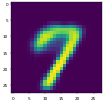

[4] sampled


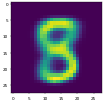

In [14]:
for i in range(5):
    z = torch.randn(1, args.hidden_size).to(model.device)
    x_hat = torch.sigmoid(model.decoder(z))
    x_hat = x_hat.squeeze(1).permute(1, 2, 0).detach().cpu().numpy().squeeze()
    print(f"[{i}] sampled")
    plt.figure(dpi=30)
    plt.imshow(x_hat)
    plt.show()